Import Block

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-bawang-putih-malang-2017-2021.csv?token=ARB4LTC6LBIK725ET5C4E6TAXYXYO \
    -O /tmp/garlic.csv

--2021-05-31 14:48:28--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-bawang-putih-malang-2017-2021.csv?token=ARB4LTC6LBIK725ET5C4E6TAXYXYO
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15983 (16K) [text/plain]
Saving to: ‘/tmp/garlic.csv’

/tmp/garlic.csv     100%[===================>]  15.61K  --.-KB/s    in 0s      

2021-05-31 14:48:29 (32.2 MB/s) - ‘/tmp/garlic.csv’ saved [15983/15983]



In [3]:
#Read dataset with pandas, then put it to garlic_df variable
garlic_df = pd.read_csv('/tmp/garlic.csv')
garlic_df

tanggal  harga
0    2017-08-02  16000
1    2017-08-03  16000
2    2017-08-04  16000
3    2017-08-07  16000
4    2017-08-08  16000
..          ...    ...
935  2021-05-24  18750
936  2021-05-25  18750
937  2021-05-27  18500
938  2021-05-28  18500
939  2021-05-31  18500

[940 rows x 2 columns]

In [4]:
#Inspect the first 5 of garlic_df dataframe
garlic_df.head()

tanggal  harga
0  2017-08-02  16000
1  2017-08-03  16000
2  2017-08-04  16000
3  2017-08-07  16000
4  2017-08-08  16000

In [5]:
#Inspect the last 5 of garlic_df dataframe
garlic_df.tail()

tanggal  harga
935  2021-05-24  18750
936  2021-05-25  18750
937  2021-05-27  18500
938  2021-05-28  18500
939  2021-05-31  18500

In [6]:
#Inspect the describtion of garlic_df dataframe
garlic_df.describe()

harga
count    940.000000
mean   18491.914894
std     6440.075502
min     9000.000000
25%    14000.000000
50%    17000.000000
75%    21500.000000
max    50000.000000

In [7]:
#Casting harga's column to float
garlic_df['harga'] = pd.to_numeric(garlic_df['harga'], downcast='float')
print(garlic_df)
print(garlic_df.dtypes)

        tanggal    harga
0    2017-08-02  16000.0
1    2017-08-03  16000.0
2    2017-08-04  16000.0
3    2017-08-07  16000.0
4    2017-08-08  16000.0
..          ...      ...
935  2021-05-24  18750.0
936  2021-05-25  18750.0
937  2021-05-27  18500.0
938  2021-05-28  18500.0
939  2021-05-31  18500.0

[940 rows x 2 columns]
tanggal     object
harga      float32
dtype: object


In [8]:
#Normalize harga's column data by dividing it with the largest number
max = garlic_df['harga'].max()
garlic_df['harga'] /= max

In [9]:
garlic_df

tanggal  harga
0    2017-08-02  0.320
1    2017-08-03  0.320
2    2017-08-04  0.320
3    2017-08-07  0.320
4    2017-08-08  0.320
..          ...    ...
935  2021-05-24  0.375
936  2021-05-25  0.375
937  2021-05-27  0.370
938  2021-05-28  0.370
939  2021-05-31  0.370

[940 rows x 2 columns]

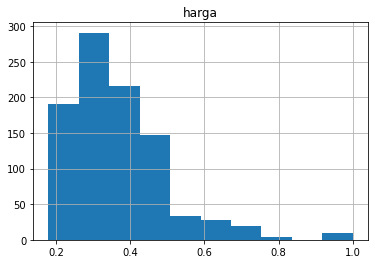

In [10]:
_ = garlic_df.hist()

In [11]:
#Get the price and time step from dataframe
temp = garlic_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [12]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

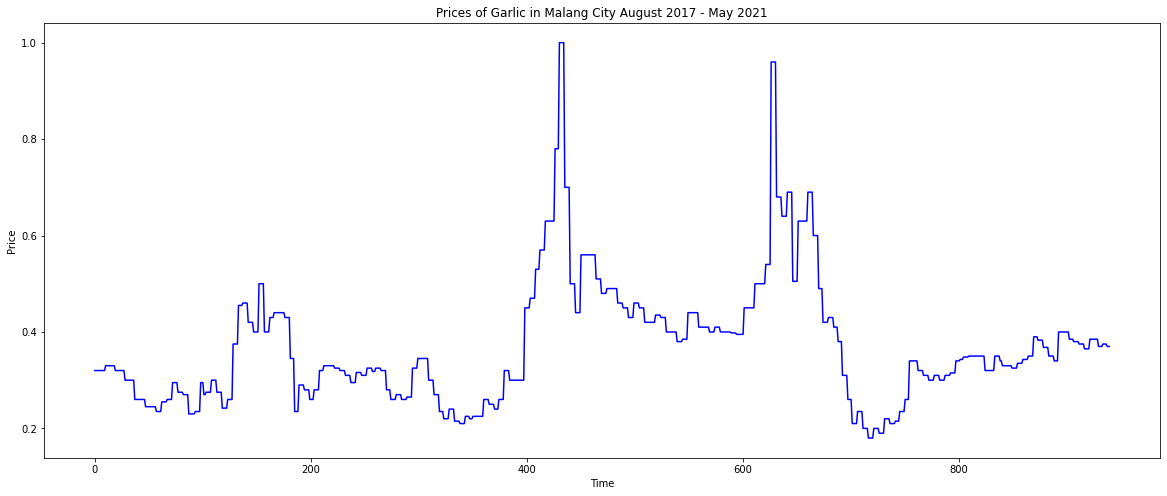

In [13]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Garlic in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

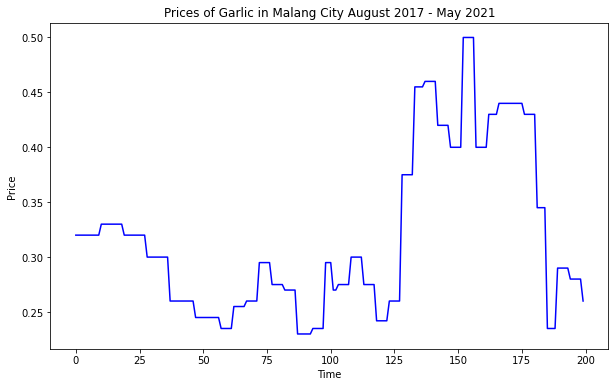

In [29]:
plt.figure(figsize=(10, 6))
plot_dataset(time=time[:200], series=price[:200], color='b', title='Prices of Garlic in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

Split Train and Test

In [15]:
#Split dataset with 70% of training, 20% for validation, and the rest for testing
split = round(0.7*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

Window the Dataset 

In [16]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [17]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  print(data_forecast)
  forecast = model.predict(data_forecast)
  return forecast

Window Size, Batch Size, & Shuffle Buffer

In [18]:
window_size = 100
batch_size = 512
shuffle_buffer = 1000

Build the Model

In [21]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=200, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/200
2/2 [==============================] - 34s 184ms/step - loss: 0.0974 - mean_absolute_error: 0.4165
Epoch 2/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0974 - mean_absolute_error: 0.4165
Epoch 3/200
2/2 [==============================] - 0s 25ms/step - loss: 0.0974 - mean_absolute_error: 0.4165
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.0974 - mean_absolute_error: 0.4165
Epoch 5/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0974 - mean_absolute_error: 0.4165
Epoch 6/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0974 - mean_absolute_error: 0.4165
Epoch 7/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0974 - mean_absolute_error: 0.4165
Epoch 8/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0974 - mean_absolute_error: 0.4165
Epoch 9/200
2/2 [========

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 16)          3136      
_________________________________________________________________
dense (Dense)                (None, None, 16)          272       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 11,937
Trainable params: 11,937
Non-trainable params: 0
_________________________________________________________________


(1e-08, 0.1, 0.0, 0.2)

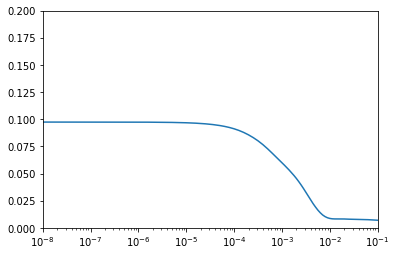

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 0.2])

In [19]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=150, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/150
2/2 [==============================] - 34s 1s/step - loss: 0.0607 - mean_absolute_error: 0.3193 - val_loss: 0.0098 - val_mean_absolute_error: 0.0953
Epoch 2/150
2/2 [==============================] - 0s 196ms/step - loss: 0.0121 - mean_absolute_error: 0.1197 - val_loss: 0.0348 - val_mean_absolute_error: 0.2445
Epoch 3/150
2/2 [==============================] - 0s 191ms/step - loss: 0.0349 - mean_absolute_error: 0.2452 - val_loss: 0.0186 - val_mean_absolute_error: 0.1733
Epoch 4/150
2/2 [==============================] - 0s 196ms/step - loss: 0.0147 - mean_absolute_error: 0.1444 - val_loss: 0.0098 - val_mean_absolute_error: 0.0955
Epoch 5/150
2/2 [==============================] - 0s 188ms/step - loss: 0.0123 - mean_absolute_error: 0.1117 - val_loss: 0.0202 - val_mean_absolute_error: 0.1613
Epoch 6/150
2/2 [==============================] - 0s 199ms/step - loss: 0.0192 - mean

In [20]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


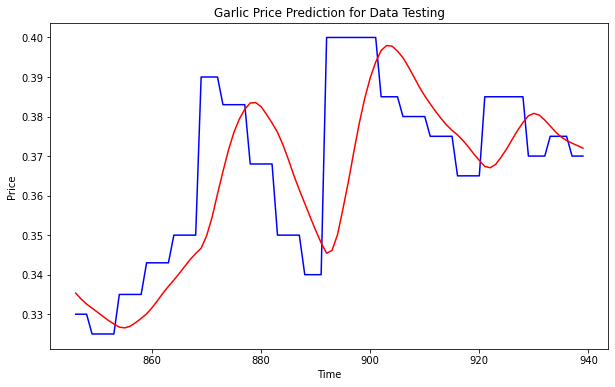

In [21]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Garlic Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Garlic Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

<Figure size 432x288 with 0 Axes>

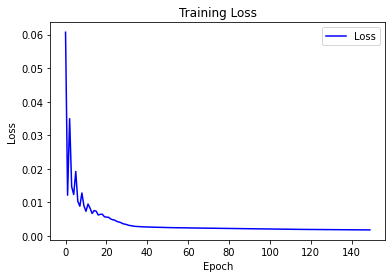

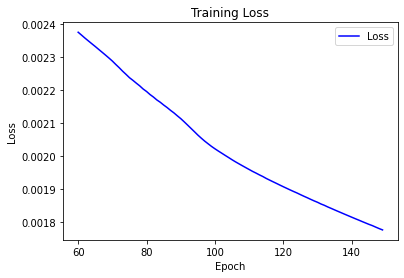

<Figure size 432x288 with 0 Axes>

In [22]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[60:]
epoch_num_zoom = [x+60 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

In [23]:
rnn_forecast

array([0.33534366, 0.3338369 , 0.33256185, 0.33153766, 0.3305064 ,
       0.32946044, 0.3284228 , 0.327532  , 0.326729  , 0.3265494 ,
       0.32697394, 0.32788754, 0.328917  , 0.33009478, 0.33163968,
       0.33342698, 0.3353266 , 0.33704454, 0.33863416, 0.34034044,
       0.34210104, 0.3438456 , 0.3453514 , 0.3466941 , 0.34980047,
       0.3545107 , 0.36041236, 0.3660939 , 0.37147087, 0.3759669 ,
       0.37936574, 0.38184714, 0.3834145 , 0.38353705, 0.3824756 ,
       0.3805302 , 0.3783747 , 0.37600976, 0.37284666, 0.36912784,
       0.3651086 , 0.36144835, 0.3580168 , 0.35455728, 0.3512023 ,
       0.34805453, 0.3454196 , 0.34615067, 0.3501082 , 0.35665205,
       0.36357442, 0.3711555 , 0.37835988, 0.3846425 , 0.38978523,
       0.39377072, 0.39669693, 0.39796144, 0.39780754, 0.39654672,
       0.394881  , 0.39259052, 0.39004657, 0.38749254, 0.38520864,
       0.38319632, 0.38127893, 0.37948966, 0.3778498 , 0.37649783,
       0.37535268, 0.37394324, 0.37230915, 0.3705192 , 0.36890

In [24]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [25]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


[[[0.37251439690589905],
  [0.3587713837623596],
  [0.35556939244270325],
  [0.3560240566730499],
  [0.36434629559516907],
  [0.37518590688705444],
  [0.3859236240386963],
  [0.3948749899864197],
  [0.4013921916484833],
  [0.40544694662094116],
  [0.4065850079059601],
  [0.4053177237510681],
  [0.40226465463638306],
  [0.39840444922447205],
  [0.3942506015300751],
  [0.39029183983802795],
  [0.38681429624557495],
  [0.38380974531173706],
  [0.38112926483154297],
  [0.37871864438056946]]]

In [26]:
round(rnn_forecast[-1][-1][0]*max)

18936

In [27]:
model.save("garlic_model")

INFO:tensorflow:Assets written to: garlic_model/assets


INFO:tensorflow:Assets written to: garlic_model/assets


In [28]:
!zip -r garlic_model.zip garlic_model

  adding: garlic_model/ (stored 0%)
  adding: garlic_model/assets/ (stored 0%)
  adding: garlic_model/keras_metadata.pb (deflated 91%)
  adding: garlic_model/saved_model.pb (deflated 90%)
  adding: garlic_model/variables/ (stored 0%)
  adding: garlic_model/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: garlic_model/variables/variables.index (deflated 66%)
